# doc2date: A Case Study in Document Regression
# Part 1: Exploratory data analysis

## Contents

1. [Contents](#Contents)
2. [HTRC word frequencies dataset](#HTRC-word-frequencies-dataset)
3. [Yearly aggregate data](#Yearly-aggregate-data)
4. [A lesson in scaling](#A-lesson-in-scaling)
5. [Aside: Dimensional reduction](#Aside:-Dimensional-reduction)
6. [Regression analysis](#Regression-analysis)

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Yearly aggregate data

We'll start by looking at yearly aggregate data for fiction, the largest of the three sub-collections. We'll ignore the OCR correction labels for now. Note that the documentation for this dataset specifies that there are three "special" tokens: "#ALLTOKENS", "#ALPHABETIC", AND "#DICTIONARYWORD". We'll drop these from the table for now.

In [2]:
htrc_dir = 'data/htrc/'
summary_file = 'fiction_yearly_summary.csv'

summary = pd.read_csv(os.path.join(htrc_dir, summary_file), usecols=['year', 'word', 'termfreq'])
summary = summary[~summary['word'].str.contains('#')]

Taking a quick look at this dataframe, we see that it essentially consists of frequency assignments to `(year, word)` pairs.

In [3]:
summary.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
year,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701
word,',a,further,native,forgot,mayor,wonder,incapable,reflections,absence
termfreq,162,813,2,1,9,1,13,3,5,5


Let's first identify, tokenize, and measure the size of the vocabulary.

In [4]:
token2word = dict(enumerate(summary['word'].unique()))
word2token = { v: k for k, v in token2word.items() }
vocab_size = len(token2word)

summary['token'] = summary['word'].map(word2token)

It seems more sensible to organize the dataframe using a hierarchical multi-index as follows.

In [5]:
summary = summary.set_index(['year', 'token'])
summary

word  termfreq
year token                       
1701 0                '       162
     1                a       813
     2          further         2
     3           native         1
     4           forgot         9
...                 ...       ...
1922 6166        roused      4282
     7095     hereafter       973
     3317   countenance      6190
     9510   kindhearted       510
     8167         clasp      1304

[1873544 rows x 2 columns]

We'd like to organize this data into a term frequency matrix with rows corresponding to years and columns to words. To accomplish, let's first add in the missing rows corresponding to words with 0 (counted) occurences in a particular year.

In [6]:
index = pd.MultiIndex.from_product([summary.index.levels[0], range(0, vocab_size)])
summary = summary.reindex(index).fillna(0)

Now we can now simply `unstack` our dataframe into a matrix.

In [7]:
summary_matrix = summary['termfreq'].unstack()
summary_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
year,,,,,,,,,,,,,,,,,,,,,
1701,162.0,813.0,2.0,1.0,9.0,1.0,13.0,3.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1702,31.0,252.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1703,2495.0,6381.0,126.0,4.0,17.0,0.0,85.0,5.0,12.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1706,224.0,700.0,6.0,3.0,0.0,0.0,13.0,0.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1708,1556.0,10041.0,93.0,7.0,42.0,0.0,59.0,4.0,75.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following arrays will be our input and target variables.

In [8]:
X = summary_matrix.to_numpy()
y = summary.index.levels[0]

Let's look at the distribution of terms throughout the entire corpus. We'll make a bar plot of the total frequency of the most common words.

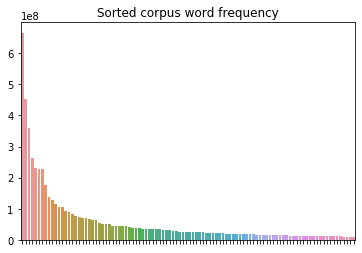

In [9]:
import matplotlib.ticker as ticker

a = 0
b = 100
freqs = np.sum(X, axis=0)
ax = sns.barplot(np.arange(b - a), np.sort(freqs)[::-1][a:b])
ax.set_title('Sorted corpus word frequency')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter(''))

This seems to be a manifestation of [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law).

Let's see which words are the most common.

In [10]:
print('Most common words:')
print([token2word[t] for t in np.argsort(freqs)][-15:])

Most common words:
['his', 'it', 'that', 'was', 'he', 'in', 'i', 'a', 'to', '"', 'of', 'and', '.', 'the', ',']


Not surprisingly, these are stop words and punctuation. These are unlikely to be unhelpful for time-period identification, because they are so common regardless of the period. It's common to remove stop words in natural language processing tasks, however there doesn't seem to be a universal consensus on whether you should do this and it may be task-dependent. My own experience has been that stop word removal has little impact on model performance and, since the total number of stop words is relatively small, has little effect on time or memory consumption.

The most uncommon words are specific numbers, which are unlikely to occur in more than one or a few texts.

In [11]:
print('Most uncommon words:')
print([token2word[t] for t in np.argsort(freqs)][:15])

Most uncommon words:
['279', '269', '261', '265', '273', '271', '251', '263', '255', '267', '115', '257', '259', '253', '151']


These may be helpful for identifying a particular year by aggregate word count but are unlikely to be much use when we are trying to date specific volumes of text; in that case, although these words may help identify a particular volume, relying on them hurts generalization ability (they contribute to the [variance](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) of the statistical models we will build).

I've found that removing uncommon words can be quite a delicate task: Words that are too uncommon will not help our models generalize; on the other hand, the words most likely to signal that our training example has some target value are likely to be amongst the less common words. When it comes to time and memory usage, removing uncommon words can be enormously helpful because there are so many of them, as can be seen from Zipf's law.

## A lesson in scaling

It's often tempting to "blindly" try to fit a model to data to see the result. Especially when the model is very simple, what's the worst that can happen? There's nothing wrong with doing this, and in fact it can be very informative; afterwards, care should be taken to try to understand the result before moving on to more complex models.

Suppose we apply linear regression to our data, making sure to properly standardize and split it first.

In [9]:
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

reg = LinearRegression()
reg.fit(X_train, y_train)
print('R^2 (linear regression):', reg.score(X_test, y_test))

R^2 (linear regression): -47.08334052309754


This result shouldn't be surprising: our data is very high-dimensional, i.e. we have more features (10000) than training examples (around 200). Geometrically, there are many possible regression coefficients that could fit the training data perfectly, but we shouldn't expect these to fit the test data. We are violating a major [assumption](https://en.wikipedia.org/wiki/Linear_regression#Assumptions) of linear regression:

> ...the design matrix *X* must have full column rank *p*; otherwise, we have a condition known as perfect multicollinearity in the predictor variables...

Of course, this is a well-known problem and has a well-known solution: we apply a regularization method.

In [13]:
lasso = Lasso(alpha=1000, tol=0.1)
lasso.fit(X_train, y_train)
print('R^2 (lasso):', lasso.score(X_test, y_test))

R^2 (lasso): 0.8186823941298793


Our result is much improved, we're happy, and we move on.

Or do we? The problem with this kind of "optimistic" solution is we may be learning the wrong thing. Consider the total number of words collected each year.

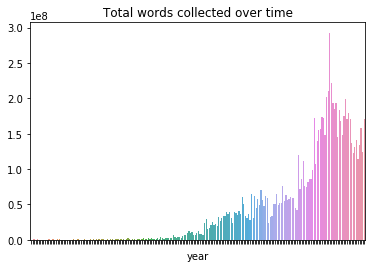

In [14]:
total_words = np.sum(X, axis=1)
ax = sns.barplot(y, total_words)
ax.set_title('Total words collected over time')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter(''))

The number increases, possibly exponentially. This is likely due to an increasingly large availability of data (the sudden drop towards the end might be explained by a decrease in available *public domain* data).

What this suggests is that we could find a reasonably good fit just by reducing each training example to its sum and performing one-dimensional linear regression on log-scaled data. In fact, let's try that.

In [15]:
def sum_log_reg(X):
    # take the sum
    X_summed = np.sum(X, axis=1).reshape(-1, 1)
    
    # add some noise to remove 0 before taking log
    X_noisy = X_summed + np.random.normal(0, 0.001, size=X_summed.shape)
    assert (X_noisy == 0).sum() == 0
    
    # split and fit
    X_train, X_test, y_train, y_test = train_test_split(np.log(X_noisy), np.log(y), test_size=0.2)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

print('R^2 (1D log-scaled OLS)', sum_log_reg(X))

R^2 (1D log-scaled OLS) 0.8991007947782701


But we don't want to learn to identify a year by looking at the total number of words published that year. This won't help us identify the publication date of a *single* document. In order to address this problem, we should consider scaled word frequencies, rather than total word count.

In [10]:
X_norm = X / np.sum(X, axis=1).reshape(-1, 1)

Now if we repeat our previous experiment, we get a poor fit.

In [17]:
print('R^2 (1D log-scaled OLS on row-normalized data):', sum_log_reg(X_norm))

R^2 (1D log-scaled OLS on row-normalized data): -0.03629304089746466


## Aside: Dimensional reduction

Our data is normalized, but we still have far more features than training examples. Moreover, there are correlations between our features and our training examples are sparse vectors. It seems in principle that our data contains a lot of redundancy that could be eliminated somehow. We already discussed one solution: regularization. Here we'll take a look at another: dimensional reduction.

In [18]:
pca = PCA(n_components=10)
X_red = pca.fit_transform(X_norm)

The following plot shows that our reduction in some sense captures most of the information we need.

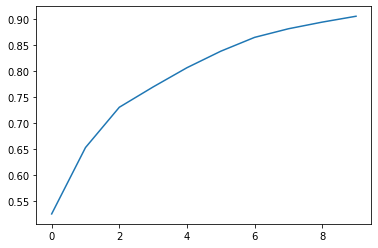

In [19]:
_ = sns.lineplot(range(10), np.cumsum(pca.explained_variance_ratio_))

It follows that we should be able to get a reasonably good fit using just these features. The following experiment shows this to be the case.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.2)

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.8836843438652379

An issue with this approach is it can be difficult to interpret the meaning of the features extracted by dimensional reduction. In the next section, we take the regularization approach.

## Regression analysis

Let's scale and split our data and apply ordinary least squares regression, but now on all 10000 features.

In [11]:
X_scaled = StandardScaler().fit_transform(X_norm)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2)

In [22]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print('R^2 (OLS)', reg.score(X_test, y_test))

R^2 (OLS) 0.858877298741254


That's quite good but it would be nice to understand which features are being used (and in what way) to make predictions. A well-known and simple way of performing automatic feature selection is with the lasso. This time, let's use cross-validation to optimize over the regularization parameter.

In [23]:
lasso = LassoCV(tol=0.01)
lasso.fit(X_train, y_train)
print('R^2 (lasso):', lasso.score(X_test, y_test))

R^2 (lasso): 0.9530992657464871


Let's see which words correspond to non-zero lasso coefficients.

In [24]:
coef = lasso.coef_
important_words = [token2word[i] for i in range(vocab_size) if coef[i] > 0]
print('Relevant features:')
print(important_words)

Relevant features:
["'", 'me', 'i', 'we', 'the', 'you', '!', 'she', 'so', 'in', 'it', "'s", 'said', 'he', 'had', 'on', '.', '"']


Let's make a pair plot from the first few of these words together with the year variable. We'll use the `summary_matrix` dataframe; we haven't normalized it yet, so this is the first step.

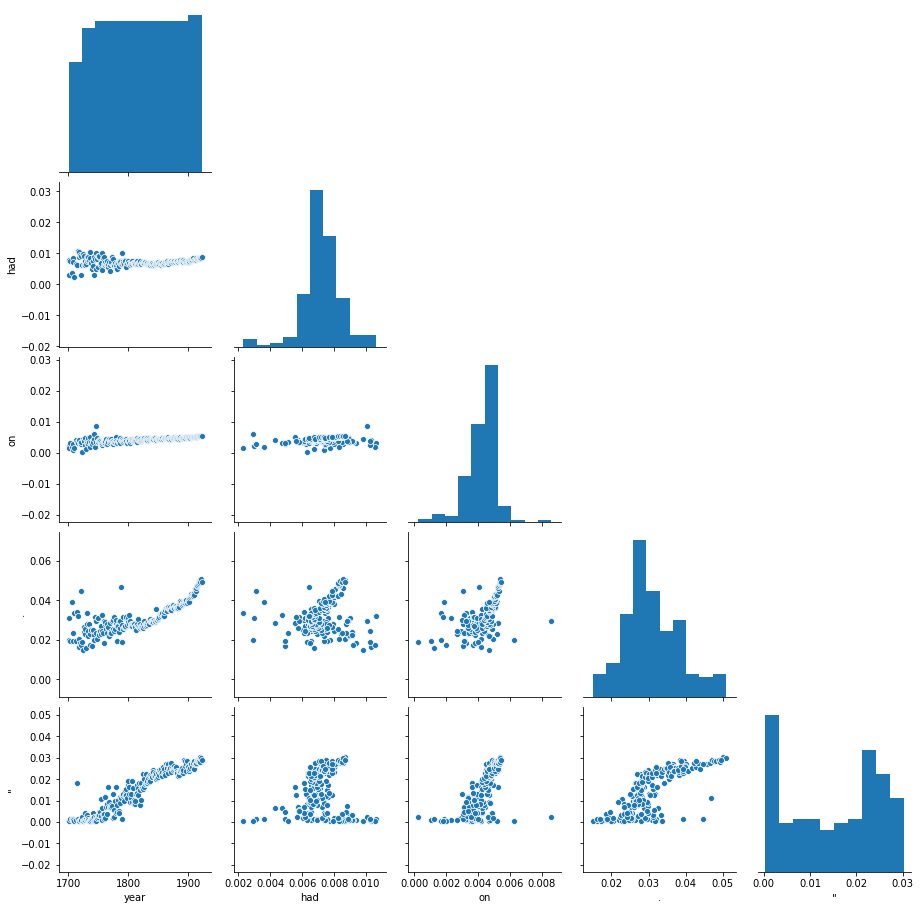

In [25]:
summary_matrix_norm = summary_matrix.apply(lambda row: row / row.sum(), axis=1)
summary_matrix_norm.columns = [token2word[t] for t in summary_matrix_norm.columns]
summary_matrix_norm['year'] = summary_matrix_norm.index

_ = sns.pairplot(summary_matrix_norm, vars=['year'] + important_words[-4:], corner=True)

To find the explantory variable that has the most explanatory power *on its own*, we'll solve one-dimensional regression problems for each of these and choose the one with the best fit.

In [26]:
regs = []
for word in important_words:
    r = LinearRegression()
    r.fit(X_train[:, word2token[word]].reshape(-1, 1), y_train)
    regs.append(r)

And the winner is...

In [27]:
scores = [r.score(X_test[:, word2token[word]].reshape(-1, 1), y_test) for r in regs]
i_best = np.argmax(scores)
print('Best-correlated feature:', important_words[i_best])
print('R^2 (OLS on best-correlated feature)', scores[i_best])

Best-correlated feature: "
R^2 (OLS on best-correlated feature) 0.8984530941073519


This is somewhat unexpected: linear regression of publication date against the frequency of quotation marks in a text fits with an $R^2$ score of 0.9. Personally, I have to see it to believe it. Let's take a look in the variation in use of this symbol over time.

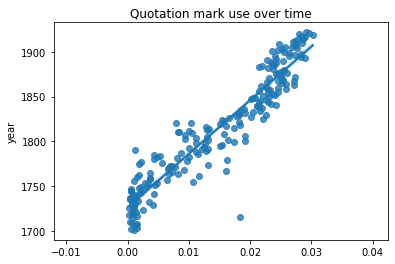

In [28]:
_ = sns.regplot(X_norm[:, word2token['"']], y).set_title('Quotation mark use over time')

As we can see, the resulting trend is indeed more-or-less linear. By way of comparison, let's do the same for a word not in our list.

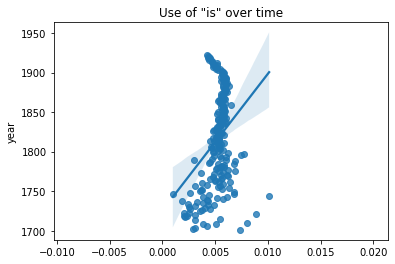

In [29]:
_ = sns.regplot(X_norm[:, word2token['is']], y).set_title('Use of "is" over time')

In this case, there is little correlation between word use and time period (although the *noisiness* of the word use does seem somewhat strongly correlated to time) and the regression model struggles.